In [1]:
# When you work in multiple projects it is strongly recommendable to work in virtual enviroments
# (Need to be run the first time you open the notebook)
!pip install virtualenv
!virtualenv env
!source env/bin/activate

"virtualenv" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"source" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [2]:
# Importing libraries
# (Need to be run the first time you open the notebook)
import sys
# update the pip package installer
!{sys.executable} -m pip install --upgrade pip
# install required packages
!{sys.executable} -m pip install --upgrade uproot awkward vector numpy matplotlib

     ------------------------------------- 320.6/320.6 kB 10.0 MB/s eta 0:00:00
     ------------------------------------- 535.3/535.3 kB 16.9 MB/s eta 0:00:00
     ------------------------------------- 673.7/673.7 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: awkward
    Found existing installation: awkward 1.10.2
    Uninstalling awkward-1.10.2:
      Successfully uninstalled awkward-1.10.2
  Attempting uninstall: uproot
    Found existing installation: uproot 4.3.7
    Uninstalling uproot-4.3.7:
      Successfully uninstalled uproot-4.3.7


In [3]:
# Mount samples from google drive
# (Need to be run the first time you open the notebook)
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
# Import libraries
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks

import infofile # local file containing cross-sections, sums of weights, dataset IDs

c:\Users\ccana\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ccana\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\ccana\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [8]:
# General analysis definition
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D
fraction = 1.0 # reduce this is if you want the code to run quicker
tuple_path = '/Users/ccana/Documents/Kitai/codigos/4lep/4lep/' #colab address

In [10]:
# Organise samples that we will work on, setting up colours for plotting
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'],
    },

    r'Background $Z,t\bar{t}$' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },

    r'Background $ZZ^*$' : { # ZZ
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },

    r'Signal ($m_H$ = 125 GeV)' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep', 'WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#00cdff" # light blue
    },

    #'Zmumu': {
    #    'list' : ['Ztautau'],
    #    'color' : "#00cdff" # light blue

#    }

}

In [11]:
# Units as stored in data files
MeV = 0.001
GeV = 1.0

In [12]:
# Function that gets data from files.
# The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.
def get_data_from_files():

    data = {} # define empty dictionary to hold awkward arrays
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append array returned from read_file to list of awkward arrays
        data[s] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays
    
    return data # return dictionary of awkward arrays

In [13]:
# Function that calculates weight of MC event
def calc_weight(xsec_weight, events):
    return (
        xsec_weight
        * events.mcWeight
        * events.scaleFactor_PILEUP
        * events.scaleFactor_ELE
        * events.scaleFactor_MUON 
        * events.scaleFactor_LepTRIGGER
    )

In [14]:
# Function that gets cross-section weight
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

In [97]:
# Function that calculates 4-lepton invariant mass

def calc_mllll(lep_pt, lep_eta, lep_phi, lep_E):
    # construct awkward 4-vector array
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    # calculate invariant mass of first 4 leptons
    # [:, i] selects the i-th lepton in each event
    # .M calculates the invariant mass
    return (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M * MeV

def calc_z1mass(lep_pt, lep_eta, lep_phi, lep_E):
    # construct awkward 4-vector array
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    # calculate invariant mass of first 4 leptons
    # [:, i] selects the i-th lepton in each event
    # .M calculates the invariant mass
    return (p4[:, 0] + p4[:, 1]).M * MeV

def calc_z2mass(lep_pt, lep_eta, lep_phi, lep_E):
    # construct awkward 4-vector array
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    # calculate invariant mass of first 2 leptons
    # [:, i] selects the i-th lepton in each event
    # .M calculates the invariant mass
    return (p4[:, 2] + p4[:, 3]).M * MeV

In [269]:
# Function that makes selection cuts
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge): 
# throw away when sum of lepton charges is not equal to 0
# first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    return lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
    return (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)

def cut_mass_z1_min(lep_pt, lep_eta, lep_phi, lep_E):
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    return (p4[:, 0] + p4[:, 1]).M *MeV <50*GeV 

def cut_mass_z1_max(lep_pt, lep_eta, lep_phi, lep_E):
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    return (p4[:, 0] + p4[:, 1]).M *MeV >106*GeV

def cut_mass_z2_min(lep_pt, lep_eta, lep_phi, lep_E):
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    return (p4[:, 2] + p4[:, 3]).M *MeV <12*GeV  

def cut_mass_z2_max(lep_pt, lep_eta, lep_phi, lep_E):
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    return  (p4[:, 2] + p4[:, 3]).M *MeV >115*GeV


def cut_lep_pt(lep_pt):
# throw away when lepton pt is less than 20 GeV
    return lep_pt[:, 0] < 6000

def cut_lep_charge_z1(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    return lep_charge[:, 0] + lep_charge[:, 1] != 0

def cut_lep_charge_z2(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    return lep_charge[:, 2] + lep_charge[:, 3] != 0

def cut_lep_type_z1(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1]
    return (sum_lep_type != 22) & (sum_lep_type != 26)

def cut_lep_type_z2(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[:, 2] + lep_type[:, 3]
    return (sum_lep_type != 22) & (sum_lep_type != 26)

def cut_lep_pt_1(lep_pt):
# throw away when lepton pt is less than 20 GeV
    return lep_pt[:, 0] < 20000

def cut_lep_pt_2(lep_pt):
# throw away when lepton pt is less than 15 GeV
    return lep_pt[:, 1] < 15000

def cut_lep_pt_3(lep_pt):
# throw away when lepton pt is less than 10 GeV
    return lep_pt[:, 2] < 10000

def cut_lep_eta(lep_eta):
# throw away when lepton eta is less than 2.7
    return lep_eta[:, 0] > 2.7  


In [376]:
# Read file, multiply weight, apply selection cuts and call observables
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = [] # define empty list to hold all data for this sample
    
    # open the tree called mini using a context manager (will automatically close files/resources)
    with uproot.open(path + ":mini") as tree:
        numevents = tree.num_entries # number of events
        if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
        for data in tree.iterate(['lep_pt','lep_eta','lep_phi',
                                  'lep_E','lep_charge','lep_type', 
                                  # add more variables here if you make cuts on them 
                                  'mcWeight','scaleFactor_PILEUP',
                                  'scaleFactor_ELE','scaleFactor_MUON',
                                  'scaleFactor_LepTRIGGER'], # variables to calculate Monte Carlo weight
                                 library="ak", # choose output type as awkward array
                                 entry_stop=numevents*fraction): # process up to numevents*fraction

            nIn = len(data) # number of events in this batch

            if 'data' not in sample: # only do this for Monte Carlo simulation files
                # multiply all Monte Carlo weights and scale factors together to give total weight
                data['totalWeight'] = calc_weight(xsec_weight, data)

            print(data.lep_pt)
            

            # cut on lepton charge using the function cut_lep_charge defined above
            #data = data[~cut_lep_charge(data.lep_charge)]
            #data= data[~cut_lep_charge_z1(data.lep_charge)]
            data= data[cut_lep_charge_z2(data.lep_charge)]
            # cut on lepton pt
            #data = data[~cut_lep_pt(data.lep_pt)]

            # cut on lepton type using the function cut_lep_type defined above
            #data = data[~cut_lep_type(data.lep_type)]
            #data= data[~cut_lep_type_z1(data.lep_type)]
            data= data[~cut_lep_type_z2(data.lep_type)]
            data= data[~cut_mass_z1_min(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)]
            data= data[~cut_mass_z1_max(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)]
            data=data[~cut_mass_z2_min(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)]
            data=data[~cut_mass_z2_max(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)]
            data = data[~cut_lep_pt_1(data.lep_pt)]
            data = data[~cut_lep_pt_2(data.lep_pt)]
            data = data[~cut_lep_pt_3(data.lep_pt)]
            data= data[~cut_lep_eta(data.lep_eta)]
            # calculation of 4-lepton invariant mass using the function calc_mllll defined above
            #data['mllll'] = calc_mllll(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)
            #data['z1mass'] = calc_z1mass(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)
            data['z2mass'] = calc_z2mass(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)
            #data['lep_pt'] = data.lep_pt


            # array contents can be printed at any stage like this
            #print(data)

            # array column can be printed at any stage like this
            #print(data['lep_pt'])

            # multiple array columns can be printed at any stage like this
            #print(data[['lep_pt','lep_eta']])

            nOut = len(data) # number of events passing cuts in this batch
            data_all.append(data) # append array from this batch
            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return ak.concatenate(data_all) # return array containing events passing all cuts

In [377]:
# Analysis loop (processing)
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing data samples
	Processing: data_A
[[4.91e+04, 4.35e+04, 4.3e+04, 2.74e+04], ... [7.3e+04, 1.3e+04, 8.97e+03, 7.45e+03]]
		 nIn: 39,	 nOut: 	3	 in 0.2s
	Processing: data_B
[[4.9e+04, 3.8e+04, 3.57e+04, 3.44e+04], ... [5.73e+04, 4.3e+04, 7.8e+03, 7.13e+03]]
		 nIn: 156,	 nOut: 	8	 in 0.2s
	Processing: data_C
[[4.16e+04, 3.55e+04, 1.52e+04, 1.23e+04, ... 5.03e+04, 7.95e+03, 7.94e+03]]
		 nIn: 237,	 nOut: 	11	 in 0.2s
	Processing: data_D
[[1.74e+05, 4.65e+04, 4.51e+04, 4.37e+04, ... 1.99e+05, 7.97e+04, 4.5e+04, 2.85e+04]]
		 nIn: 400,	 nOut: 	18	 in 0.2s
Processing Background $Z,t\bar{t}$ samples
	Processing: Zee
[[6.38e+04, 2.15e+04, 1.45e+04, 7.74e+03, ... 3.44e+04, 3.35e+04, 1.77e+04]]
		 nIn: 898,	 nOut: 	120	 in 0.2s
	Processing: Zmumu
[[4.85e+04, 3.44e+04, 1.48e+04, 7.62e+03, ... 4.56e+04, 7.82e+03, 7.57e+03]]
		 nIn: 684,	 nOut: 	75	 in 0.3s
	Processing: ttbar_lep
[[7.29e+04, 3.88e+04, 1.26e+04, 7.01e+03, ... 1.04e+04, 1.04e+04, 8.41e+03]]
		 nIn: 1031,	 nOut: 	46	 in 0.2s

In [403]:
# Plot data
def plot_data(data):

    xmin = 80 * GeV
    xmax = 240 * GeV
    step_size = 5 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(ak.to_numpy(data['data']['z2mass']),
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)']['z2mass']) # histogram the signal
    signal_weights = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'].totalWeight) # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( ak.to_numpy(data[s]['z2mass']) ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( ak.to_numpy(data[s].totalWeight) ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Signal ($m_Z$ = 91.2 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'2-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow Z2^* \rightarrow 2\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes


    
    plt.text(0.4, # x
             0.93, # y
             'Background Events=$\sum$ $n_{out}$= 18.372', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 


    plt.text(0.4, # x '$\sum=262.925$'
             0.83, # y
             'Signal Events= $\sum$ $n_{out}$ =13.714', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    
    return

## Z1

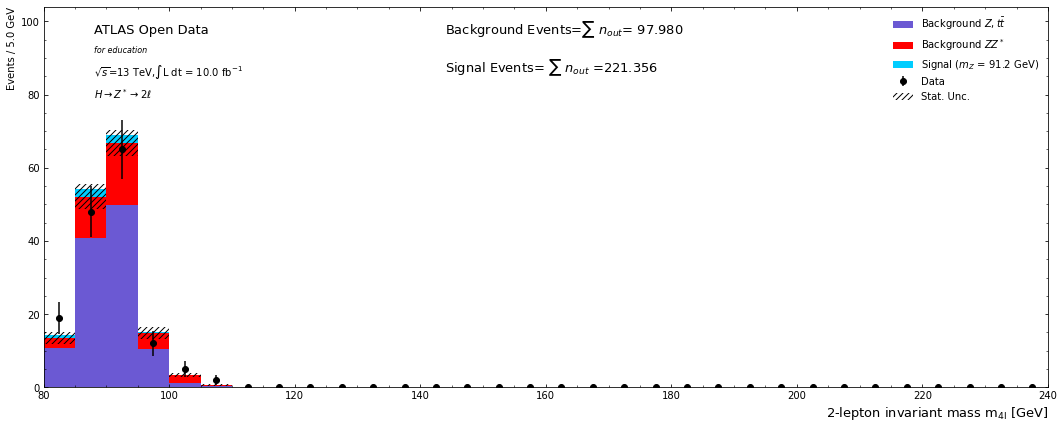

In [375]:
plt.figure(figsize = (18,7))
plot_data(data)

## Z2

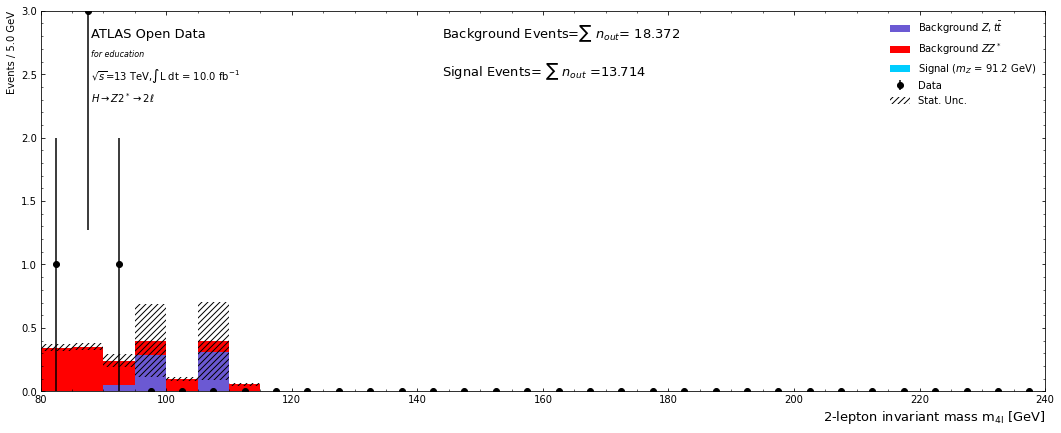

In [404]:
plt.figure(figsize = (18,7))
plot_data(data)

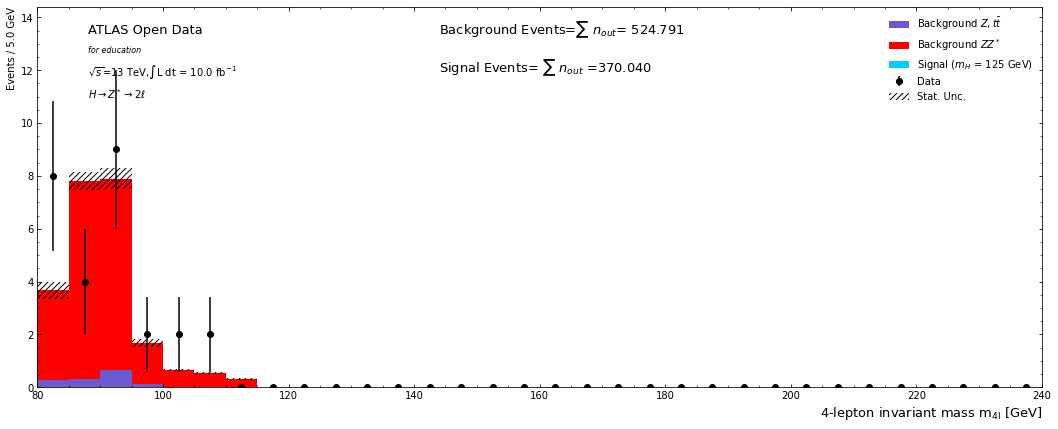

In [349]:
plt.figure(figsize = (18,7))
plot_data(data)

## All cuts

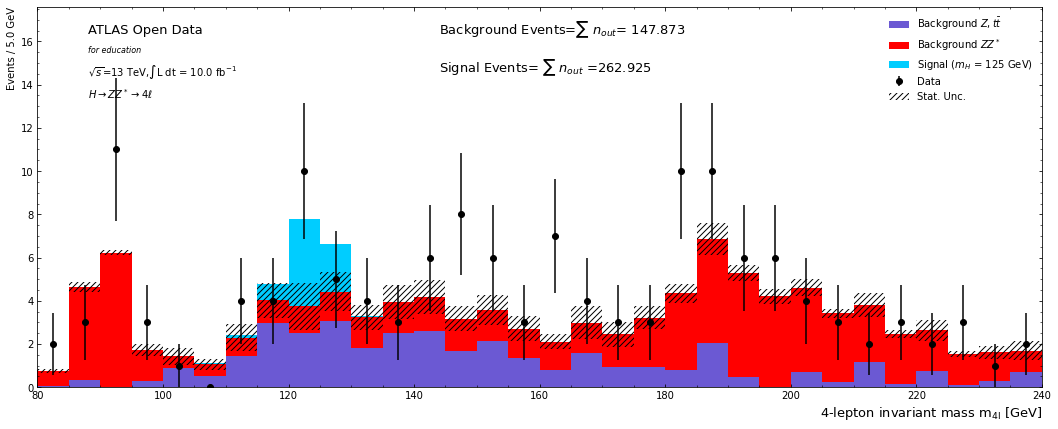

In [328]:
plt.figure(figsize = (18,7))
plot_data(data)

## cuts in class

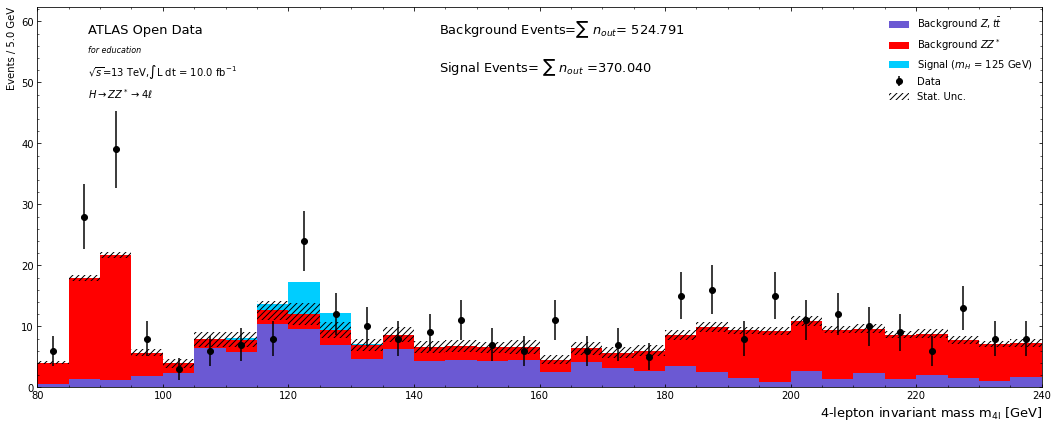

In [332]:
plt.figure(figsize = (18,7))
plot_data(data)